In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Hands-on-CV-Project2

/content/drive/MyDrive/Hands-on-CV-Project2


Imports

In [3]:
!pip -q install wandb
!pip -q install fiftyone

import os, random, time
import numpy as np
import pandas as pd
import torch
import wandb

from pathlib import Path
from torch.utils.data import DataLoader

from src.datasets import (
    AssessmentPairs, train_val_split, AssessmentTorchDataset,
    stratified_subsample, class_counts
)
from src.training import train_task3


In [4]:
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [5]:
ROOT = Path("/content/drive/MyDrive/Hands-on-CV-Project2/assessment")

pairs = AssessmentPairs(ROOT).load_pairs()
pairs_sub = stratified_subsample(pairs, frac=0.10, seed=42)  # or fixed N, e.g. 1000

train_pairs, val_pairs = train_val_split(pairs_sub, val_ratio=0.2, seed=42)

train_ds = AssessmentTorchDataset(train_pairs)
val_ds   = AssessmentTorchDataset(val_pairs)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print("ALL:", len(pairs), class_counts(pairs))
print("SUB:", len(pairs_sub), class_counts(pairs_sub))
print("train:", len(train_pairs), class_counts(train_pairs))
print("val  :", len(val_pairs), class_counts(val_pairs))

batch = next(iter(train_loader))
rgb_in_ch = batch["rgb"].shape[1]
lidar_in_ch = batch["lidar"].shape[1]
print("rgb_in_ch:", rgb_in_ch, "lidar_in_ch:", lidar_in_ch)


ALL: 19998 {'cubes': 9999, 'spheres': 9999}
SUB: 2000 {'cubes': 1000, 'spheres': 1000}
train: 1600 {'cubes': 810, 'spheres': 790}
val  : 400 {'cubes': 190, 'spheres': 210}
rgb_in_ch: 4 lidar_in_ch: 1


In [ ]:
from pathlib import Path
import pandas as pd
import wandb

from src.models import build_fusion_model

PROJECT = "cilp-extended-assessment"

EPOCHS = 20
LR = 1e-3
EMB = 200

Path("checkpoints").mkdir(exist_ok=True)

results = []

def run_one(model_key: str, pool_type: str, model, config_extra: dict):
    run = wandb.init(
        project=PROJECT,
        name=f"task4_{pool_type}_{model_key}",
        config={
            "task": 4,
            "model": model_key,
            "pool_type": pool_type,           # "maxpool" or "strided"
            "epochs": EPOCHS,
            "lr": LR,
            "emb": EMB,
            "batch_size": train_loader.batch_size,
            "train_size": len(train_loader.dataset),
            "val_size": len(val_loader.dataset),
            **config_extra,
        },
        reinit=True,
    )

    ckpt_path = f"checkpoints/task4_{pool_type}_{model_key}.pt"

    out = train_task3(
        model,
        train_loader,
        val_loader,
        device=device,
        epochs=EPOCHS,
        lr=LR,
        wandb_run=run,
        ckpt_path=ckpt_path,
    )

    run.finish()

    results.append({
        "model": model_key,
        "pool_type": pool_type,
        "ckpt_path": ckpt_path,
        "val_loss_final": out["val_loss_final"],
        "val_f1_final": out.get("val_f1_final", None),
        "params": out["params"],
        "sec_per_epoch_avg": out["sec_per_epoch_avg"],
        "gpu_mem_mb_peak": out["gpu_mem_mb_peak"],
    })


for pool_type in ["maxpool", "strided"]:
    # late fusion
    model_key = "late_fusion"
    model = build_fusion_model(
        "late",
        rgb_in_ch=rgb_in_ch,
        lidar_in_ch=lidar_in_ch,
        emb_size=EMB,
        num_classes=2,
        pool_type=pool_type,
        normalize_embeddings=False,
    )
    run_one(model_key, pool_type, model, config_extra={"fusion": "late", "fusion_op": "concat_embeddings"})

    # intermediate variants
    for fusion in ["concat", "add", "hadamard"]:
        model_key = f"intermediate_{fusion}"
        model = build_fusion_model(
            "intermediate",
            fusion=fusion,
            rgb_in_ch=rgb_in_ch,
            lidar_in_ch=lidar_in_ch,
            emb_size=EMB,
            num_classes=2,
            pool_type=pool_type,
            normalize_embeddings=False,
        )
        run_one(model_key, pool_type, model, config_extra={"fusion": "intermediate", "fusion_op": fusion})


df = pd.DataFrame(results)
df


wandb: Currently logged in as: constantin-auga (Conscht-Sht) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


epoch 01 | train 0.7120 | val 0.6936 | f1 0.322 | 12.76s | 528 MB
epoch 02 | train 0.6115 | val 0.5627 | f1 0.705 | 12.40s | 528 MB
epoch 03 | train 0.4877 | val 0.4752 | f1 0.754 | 11.21s | 528 MB
epoch 04 | train 0.4055 | val 0.3810 | f1 0.833 | 12.34s | 528 MB
epoch 05 | train 0.3129 | val 0.2851 | f1 0.883 | 12.07s | 528 MB
epoch 06 | train 0.1942 | val 0.1899 | f1 0.934 | 11.75s | 528 MB
epoch 07 | train 0.1385 | val 0.2299 | f1 0.930 | 11.05s | 528 MB
epoch 08 | train 0.1378 | val 0.1881 | f1 0.932 | 11.06s | 528 MB
epoch 09 | train 0.0784 | val 0.1214 | f1 0.949 | 11.73s | 528 MB
epoch 10 | train 0.0933 | val 0.0427 | f1 0.980 | 11.73s | 528 MB
epoch 11 | train 0.4209 | val 0.2976 | f1 0.883 | 11.84s | 528 MB
epoch 12 | train 0.4396 | val 0.6929 | f1 0.322 | 10.97s | 528 MB
epoch 13 | train 0.4056 | val 0.3454 | f1 0.852 | 10.75s | 528 MB
epoch 14 | train 0.2176 | val 0.2081 | f1 0.906 | 11.31s | 528 MB
epoch 15 | train 0.1401 | val 0.2083 | f1 0.913 | 11.03s | 528 MB
epoch 16 |

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
perf/gpu_mem_mb_peak,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/sec_per_epoch,█▇▃▇▆▅▂▂▅▄▅▂▁▃▂▃▁▁▂▃
train/loss,█▇▆▅▄▃▂▂▂▂▅▅▅▃▂▂▂▂▁▁
val/f1_macro,▁▅▆▆▇▇▇▇██▇▁▇▇▇▇▇███
val/loss,█▇▆▅▄▃▃▃▂▁▄█▄▃▃▅▃▂▁▁
epoch,20
gpu_mem_mb_peak,527.56689
params,1305536
perf/gpu_mem_mb_peak,527.56689
perf/sec_per_epoch,11.16718


epoch 01 | train 0.6998 | val 0.6932 | f1 0.367 | 11.30s | 667 MB
epoch 02 | train 0.6920 | val 0.6837 | f1 0.334 | 11.60s | 667 MB
epoch 03 | train 0.5864 | val 0.5210 | f1 0.730 | 11.44s | 667 MB
epoch 04 | train 0.4772 | val 0.4813 | f1 0.780 | 11.21s | 667 MB
epoch 05 | train 0.4222 | val 0.4741 | f1 0.774 | 10.88s | 667 MB
epoch 06 | train 0.3956 | val 0.4294 | f1 0.810 | 11.51s | 667 MB
epoch 07 | train 0.3523 | val 0.3379 | f1 0.854 | 11.62s | 667 MB
epoch 08 | train 0.3320 | val 0.3642 | f1 0.861 | 11.48s | 667 MB
epoch 09 | train 0.2973 | val 0.3555 | f1 0.861 | 10.69s | 667 MB
epoch 10 | train 0.2134 | val 0.2341 | f1 0.913 | 10.82s | 667 MB
epoch 11 | train 0.1309 | val 0.1836 | f1 0.926 | 11.40s | 667 MB
epoch 12 | train 0.2235 | val 0.2216 | f1 0.908 | 11.41s | 667 MB
epoch 13 | train 0.0947 | val 0.1158 | f1 0.960 | 11.05s | 667 MB
epoch 14 | train 0.0720 | val 0.0829 | f1 0.955 | 11.11s | 667 MB
epoch 15 | train 0.0841 | val 0.0783 | f1 0.992 | 11.09s | 667 MB
epoch 16 |

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
perf/gpu_mem_mb_peak,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/sec_per_epoch,▆█▇▅▃▇█▇▂▃▇▇▄▅▅█▇▆▄▁
train/loss,██▇▆▅▅▄▄▄▃▂▃▂▁▂▁▂▃▁▁
val/f1_macro,▁▁▅▆▆▆▆▇▇▇▇▇█████▇██
val/loss,██▆▆▆▅▄▅▅▃▃▃▂▂▂▁▁▂▁▂
epoch,20
gpu_mem_mb_peak,667.48877
params,879236
perf/gpu_mem_mb_peak,667.48877
perf/sec_per_epoch,10.50649


epoch 01 | train 0.6992 | val 0.6989 | f1 0.322 | 11.05s | 486 MB
epoch 02 | train 0.6939 | val 0.6938 | f1 0.322 | 10.56s | 486 MB
epoch 03 | train 0.6930 | val 0.6938 | f1 0.322 | 11.26s | 486 MB
epoch 04 | train 0.6097 | val 0.5623 | f1 0.707 | 11.37s | 486 MB
epoch 05 | train 0.5214 | val 0.5387 | f1 0.699 | 11.35s | 486 MB
epoch 06 | train 0.5084 | val 0.5734 | f1 0.647 | 10.76s | 486 MB
epoch 07 | train 0.4980 | val 0.5535 | f1 0.666 | 10.80s | 486 MB
epoch 08 | train 0.5044 | val 0.4806 | f1 0.774 | 11.18s | 486 MB
epoch 09 | train 0.4221 | val 0.4248 | f1 0.793 | 11.20s | 486 MB
epoch 10 | train 0.3709 | val 0.3502 | f1 0.842 | 11.20s | 486 MB
epoch 11 | train 0.3262 | val 0.7459 | f1 0.638 | 10.57s | 486 MB
epoch 12 | train 0.3390 | val 0.3351 | f1 0.833 | 10.91s | 486 MB
epoch 13 | train 0.2300 | val 0.2813 | f1 0.880 | 11.02s | 486 MB
epoch 14 | train 0.2138 | val 0.3929 | f1 0.847 | 11.21s | 486 MB
epoch 15 | train 0.2036 | val 0.2262 | f1 0.914 | 10.88s | 486 MB
epoch 16 |

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
perf/gpu_mem_mb_peak,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/sec_per_epoch,▅▁▇██▃▃▆▇▇▁▄▅▇▄▁▆▆▆▂
train/loss,███▇▆▆▆▆▅▄▄▄▃▃▃▃▂▂▁▁
val/f1_macro,▁▁▁▅▅▅▅▆▆▇▅▇▇▇█▇████
val/loss,▇▇▇▆▆▆▆▅▄▃█▃▃▄▂▄▁▂▁▁
epoch,20
gpu_mem_mb_peak,486.09912
params,699236
perf/gpu_mem_mb_peak,486.09912
perf/sec_per_epoch,10.61075


epoch 01 | train 0.6940 | val 0.6930 | f1 0.322 | 10.97s | 499 MB
epoch 02 | train 0.5884 | val 0.5275 | f1 0.720 | 10.56s | 499 MB
epoch 03 | train 0.4507 | val 0.4086 | f1 0.807 | 11.12s | 499 MB
epoch 04 | train 0.3630 | val 0.3881 | f1 0.819 | 11.19s | 499 MB
epoch 05 | train 0.2464 | val 0.5585 | f1 0.816 | 11.08s | 499 MB
epoch 06 | train 0.2349 | val 0.2296 | f1 0.877 | 10.95s | 499 MB
epoch 07 | train 0.1712 | val 0.2054 | f1 0.934 | 10.67s | 499 MB
epoch 08 | train 0.1501 | val 0.2289 | f1 0.934 | 11.00s | 499 MB
epoch 09 | train 0.1072 | val 0.0784 | f1 0.977 | 11.15s | 499 MB
epoch 10 | train 0.0438 | val 0.0667 | f1 0.977 | 11.09s | 499 MB
epoch 11 | train 0.0617 | val 0.0803 | f1 0.965 | 10.57s | 499 MB
epoch 12 | train 0.0472 | val 0.0219 | f1 0.995 | 10.75s | 499 MB
epoch 13 | train 0.0221 | val 0.0491 | f1 0.985 | 11.19s | 499 MB
epoch 14 | train 0.0292 | val 0.0559 | f1 0.985 | 11.30s | 499 MB
epoch 15 | train 0.0590 | val 0.0510 | f1 0.982 | 11.00s | 499 MB
epoch 16 |

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
perf/gpu_mem_mb_peak,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/sec_per_epoch,▅▂▆▇▆▅▃▅▇▆▂▃▇█▅▁▇▆▅▂
train/loss,█▇▆▅▃▃▃▃▂▁▂▁▁▁▂▁▁▁▁▁
val/f1_macro,▁▅▆▆▆▇▇▇████████████
val/loss,█▆▅▅▇▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁
epoch,20
gpu_mem_mb_peak,498.85498
params,699236
perf/gpu_mem_mb_peak,498.85498
perf/sec_per_epoch,10.60456


epoch 01 | train 0.7073 | val 0.6950 | f1 0.322 | 10.96s | 101 MB
epoch 02 | train 0.6936 | val 0.6929 | f1 0.322 | 10.73s | 101 MB
epoch 03 | train 0.5969 | val 0.5627 | f1 0.695 | 11.37s | 101 MB
epoch 04 | train 0.4963 | val 0.5775 | f1 0.702 | 11.36s | 101 MB
epoch 05 | train 0.4940 | val 0.5161 | f1 0.718 | 10.98s | 101 MB
epoch 06 | train 0.4438 | val 0.5049 | f1 0.752 | 11.12s | 101 MB
epoch 07 | train 0.4135 | val 0.4489 | f1 0.788 | 10.98s | 101 MB
epoch 08 | train 0.4246 | val 0.4332 | f1 0.793 | 11.72s | 101 MB
epoch 09 | train 0.3812 | val 0.4017 | f1 0.809 | 11.48s | 101 MB
epoch 10 | train 0.3528 | val 0.3873 | f1 0.825 | 11.57s | 101 MB
epoch 11 | train 0.3528 | val 0.3649 | f1 0.844 | 11.25s | 101 MB
epoch 12 | train 0.3036 | val 0.3404 | f1 0.861 | 10.95s | 101 MB
epoch 13 | train 0.3253 | val 0.4313 | f1 0.802 | 11.38s | 101 MB
epoch 14 | train 0.3126 | val 0.3386 | f1 0.853 | 11.19s | 101 MB
epoch 15 | train 0.2692 | val 0.3008 | f1 0.880 | 11.49s | 101 MB
epoch 16 |

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
perf/gpu_mem_mb_peak,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/sec_per_epoch,▄▂▆▆▄▅▄█▇▇▅▄▆▅▇▅▁▄▇▄
train/loss,██▇▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁
val/f1_macro,▁▁▅▆▆▆▇▇▇▇▇▇▇▇█▇████
val/loss,██▆▆▅▅▄▄▃▃▃▂▄▂▂▃▂▂▂▁
epoch,20
gpu_mem_mb_peak,101.00146
params,1305536
perf/gpu_mem_mb_peak,101.00146
perf/sec_per_epoch,10.95941


epoch 01 | train 0.6986 | val 0.6924 | f1 0.344 | 11.62s | 105 MB
epoch 02 | train 0.6941 | val 0.6904 | f1 0.322 | 11.02s | 105 MB
epoch 03 | train 0.5799 | val 0.5980 | f1 0.670 | 10.72s | 105 MB
epoch 04 | train 0.5088 | val 0.5825 | f1 0.645 | 11.44s | 105 MB
epoch 05 | train 0.4685 | val 0.5048 | f1 0.726 | 11.39s | 105 MB
epoch 06 | train 0.4260 | val 0.4427 | f1 0.782 | 11.44s | 105 MB
epoch 07 | train 0.4250 | val 0.6748 | f1 0.559 | 11.13s | 105 MB
epoch 08 | train 0.4639 | val 0.4670 | f1 0.780 | 10.30s | 105 MB
epoch 09 | train 0.4117 | val 0.4250 | f1 0.794 | 11.08s | 105 MB
epoch 10 | train 0.3576 | val 0.3942 | f1 0.823 | 11.41s | 105 MB
epoch 11 | train 0.3030 | val 0.3377 | f1 0.858 | 11.33s | 105 MB
epoch 12 | train 0.2957 | val 0.3420 | f1 0.853 | 11.09s | 105 MB
epoch 13 | train 0.2241 | val 0.3282 | f1 0.874 | 10.61s | 105 MB
epoch 14 | train 0.1815 | val 0.3354 | f1 0.871 | 11.31s | 105 MB
epoch 15 | train 0.2292 | val 0.3106 | f1 0.880 | 11.05s | 105 MB
epoch 16 |

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
perf/gpu_mem_mb_peak,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/sec_per_epoch,█▅▃▇▇▇▅▁▅▇▆▅▃▆▅▆▂▆▆▄
train/loss,██▇▆▅▅▅▅▅▄▃▃▃▂▃▂▂▁▁▁
val/f1_macro,▁▁▅▅▆▆▄▆▆▇▇▇▇▇▇▇███▇
val/loss,██▇▇▆▅█▅▄▄▃▃▃▃▃▃▂▁▂▂
epoch,20
gpu_mem_mb_peak,105.13672
params,879236
perf/gpu_mem_mb_peak,105.13672
perf/sec_per_epoch,10.95286


epoch 01 | train 0.7006 | val 0.6941 | f1 0.322 | 11.26s | 96 MB
epoch 02 | train 0.6932 | val 0.6930 | f1 0.322 | 11.07s | 96 MB
epoch 03 | train 0.5933 | val 0.6638 | f1 0.649 | 10.75s | 96 MB
epoch 04 | train 0.5288 | val 0.5293 | f1 0.724 | 10.79s | 96 MB
epoch 05 | train 0.4783 | val 0.5087 | f1 0.738 | 10.89s | 96 MB
epoch 06 | train 0.4638 | val 0.4970 | f1 0.741 | 11.17s | 96 MB
epoch 07 | train 0.4668 | val 0.4996 | f1 0.736 | 10.78s | 96 MB
epoch 08 | train 0.4522 | val 0.4867 | f1 0.767 | 10.43s | 96 MB
epoch 09 | train 0.4346 | val 0.4721 | f1 0.772 | 11.10s | 96 MB
epoch 10 | train 0.4451 | val 0.4747 | f1 0.772 | 10.99s | 96 MB
epoch 11 | train 0.4154 | val 0.4566 | f1 0.788 | 11.16s | 96 MB
epoch 12 | train 0.4199 | val 0.4405 | f1 0.787 | 10.59s | 96 MB
epoch 13 | train 0.3699 | val 0.4001 | f1 0.810 | 10.72s | 96 MB
epoch 14 | train 0.3419 | val 0.4110 | f1 0.807 | 11.00s | 96 MB
epoch 15 | train 0.3344 | val 0.3762 | f1 0.845 | 11.09s | 96 MB
epoch 16 | train 0.2856 |

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
perf/gpu_mem_mb_peak,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/sec_per_epoch,█▆▄▄▅▇▄▁▇▆▇▂▃▆▇▄▁▅▆▇
train/loss,██▆▆▅▅▅▄▄▄▄▄▃▃▃▂▃▃▂▁
val/f1_macro,▁▁▅▆▆▆▆▇▇▇▇▇▇▇██▇▇██
val/loss,██▇▅▅▅▅▄▄▄▄▄▃▃▃▃▅▃▂▁
epoch,20
gpu_mem_mb_peak,95.5127
params,699236
perf/gpu_mem_mb_peak,95.5127
perf/sec_per_epoch,11.15412


epoch 01 | train 0.6948 | val 0.6934 | f1 0.322 | 11.13s | 96 MB
epoch 02 | train 0.6647 | val 0.6214 | f1 0.617 | 10.65s | 96 MB
epoch 03 | train 0.5363 | val 0.5277 | f1 0.707 | 10.88s | 96 MB
epoch 04 | train 0.4615 | val 0.4750 | f1 0.766 | 11.02s | 96 MB
epoch 05 | train 0.4183 | val 0.4084 | f1 0.809 | 11.24s | 96 MB
epoch 06 | train 0.3628 | val 0.3925 | f1 0.821 | 10.75s | 96 MB
epoch 07 | train 0.3590 | val 0.4547 | f1 0.783 | 10.30s | 96 MB
epoch 08 | train 0.3915 | val 0.4146 | f1 0.797 | 11.11s | 96 MB
epoch 09 | train 0.3565 | val 0.3761 | f1 0.835 | 11.01s | 96 MB
epoch 10 | train 0.3024 | val 0.3433 | f1 0.853 | 11.00s | 96 MB
epoch 11 | train 0.2853 | val 0.3586 | f1 0.849 | 10.58s | 96 MB
epoch 12 | train 0.2700 | val 0.3862 | f1 0.841 | 10.64s | 96 MB
epoch 13 | train 0.2674 | val 0.3114 | f1 0.874 | 10.91s | 96 MB
epoch 14 | train 0.2855 | val 0.3242 | f1 0.869 | 10.93s | 96 MB
epoch 15 | train 0.2531 | val 0.3286 | f1 0.861 | 10.52s | 96 MB
epoch 16 | train 0.2225 |

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
perf/gpu_mem_mb_peak,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/sec_per_epoch,▇▄▅▆█▄▁▇▆▆▃▄▆▆▃▁▆▆▅▁
train/loss,██▆▅▄▃▃▄▃▃▂▂▂▂▂▁▁▁▁▁
val/f1_macro,▁▅▆▆▇▇▇▇▇█▇▇████████
val/loss,█▇▅▄▃▃▄▃▂▂▂▃▁▁▂▂▁▁▁▁
epoch,20
gpu_mem_mb_peak,95.5127
params,699236
perf/gpu_mem_mb_peak,95.5127
perf/sec_per_epoch,10.28932


,model,pool_type,ckpt_path,val_loss_final,val_f1_final,params,sec_per_epoch_avg,gpu_mem_mb_peak
0,late_fusion,maxpool,checkpoints/task4_maxpool_late_fusion.pt,0.022475,0.992479,1305536,11.444954,527.566895
1,intermediate_concat,maxpool,checkpoints/task4_maxpool_intermediate_concat.pt,0.092517,0.969807,879236,11.230547,667.488770
2,intermediate_add,maxpool,checkpoints/task4_maxpool_intermediate_add.pt,0.168558,0.949788,699236,10.990931,486.099121
3,intermediate_hadamard,maxpool,checkpoints/task4_maxpool_intermediate_hadamar...,0.008465,0.994985,699236,10.941424,498.854980
4,late_fusion,strided,checkpoints/task4_strided_late_fusion.pt,0.256850,0.903612,1305536,11.184368,101.001465
5,intermediate_concat,strided,checkpoints/task4_strided_intermediate_concat.pt,0.228541,0.903367,879236,11.108160,105.136719
6,intermediate_add,strided,checkpoints/task4_strided_intermediate_add.pt,0.282899,0.879127,699236,10.903356,95.512695
7,intermediate_hadamard,strided,checkpoints/task4_strided_intermediate_hadamar...,0.297029,0.884821,699236,10.801840,95.512695


In [7]:
df = pd.DataFrame(results)
keep = df[["model","pool_type","val_loss_final","val_f1_final","params","sec_per_epoch_avg","gpu_mem_mb_peak"]]
keep


,model,pool_type,val_loss_final,val_f1_final,params,sec_per_epoch_avg,gpu_mem_mb_peak
0,late_fusion,maxpool,0.022475,0.992479,1305536,11.444954,527.566895
1,intermediate_concat,maxpool,0.092517,0.969807,879236,11.230547,667.488770
2,intermediate_add,maxpool,0.168558,0.949788,699236,10.990931,486.099121
3,intermediate_hadamard,maxpool,0.008465,0.994985,699236,10.941424,498.854980
4,late_fusion,strided,0.256850,0.903612,1305536,11.184368,101.001465
5,intermediate_concat,strided,0.228541,0.903367,879236,11.108160,105.136719
6,intermediate_add,strided,0.282899,0.879127,699236,10.903356,95.512695
7,intermediate_hadamard,strided,0.297029,0.884821,699236,10.801840,95.512695


In [8]:
pivot = keep.pivot(index="model", columns="pool_type", values=["val_loss_final","val_f1_final","params","sec_per_epoch_avg","gpu_mem_mb_peak"])
pivot


val_loss_final           val_f1_final            \
pool_type                    maxpool   strided      maxpool   strided   
model                                                                   
intermediate_add            0.168558  0.282899     0.949788  0.879127   
intermediate_concat         0.092517  0.228541     0.969807  0.903367   
intermediate_hadamard       0.008465  0.297029     0.994985  0.884821   
late_fusion                 0.022475  0.256850     0.992479  0.903612   

                          params            sec_per_epoch_avg             \
pool_type                maxpool    strided           maxpool    strided   
model                                                                      
intermediate_add        699236.0   699236.0         10.990931  10.903356   
intermediate_concat     879236.0   879236.0         11.230547  11.108160   
intermediate_hadamard   699236.0   699236.0         10.941424  10.801840   
late_fusion            1305536.0  1305536.0         11.444954  11.184368   

                      gpu_mem_mb_peak              
pool_type                     maxpool     strided  
model                                              
intermediate_add           486.099121   95.512695  
intermediate_concat        667.488770  105.136719  
intermediate_hadamard      498.854980   95.512695  
late_fusion                527.566895  101.001465

In [9]:
diff = pivot.xs("strided", level=1, axis=1) - pivot.xs("maxpool", level=1, axis=1)
diff


,val_loss_final,val_f1_final,params,sec_per_epoch_avg,gpu_mem_mb_peak
model,,,,,
intermediate_add,0.114341,-0.070661,0.0,-0.087575,-390.586426
intermediate_concat,0.136024,-0.066440,0.0,-0.122387,-562.352051
intermediate_hadamard,0.288564,-0.110163,0.0,-0.139583,-403.342285
late_fusion,0.234375,-0.088867,0.0,-0.260586,-426.565430


Save all

  pool_type                  model  val_loss_final  val_f1_final  \
0   maxpool  intermediate_hadamard        0.008465      0.994985   
1   strided    intermediate_concat        0.228541      0.903367   

   sec_per_epoch_avg  params  
0          10.941424  699236  
1          11.108160  879236  


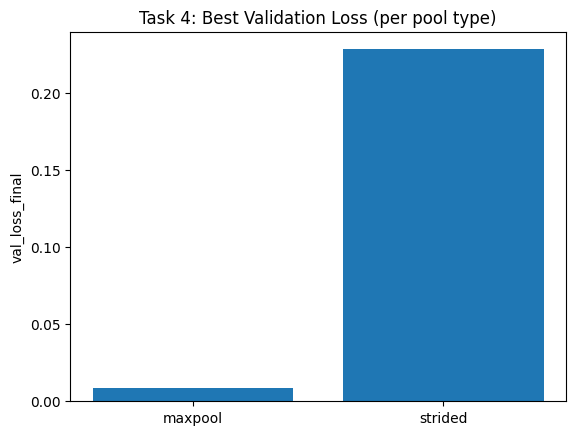

In [11]:
from pathlib import Path
import matplotlib.pyplot as plt

Path("results").mkdir(exist_ok=True)

# Best (minimum) validation loss within each pool type
best = df.loc[df.groupby("pool_type")["val_loss_final"].idxmin()].reset_index(drop=True)
best.to_csv("results/task4_pool_vs_strided_best.csv", index=False)

maxpool_val = float(best.loc[best["pool_type"] == "maxpool", "val_loss_final"].iloc[0])
strided_val = float(best.loc[best["pool_type"] == "strided", "val_loss_final"].iloc[0])

# Optional: show which models they were
print(best[["pool_type", "model", "val_loss_final", "val_f1_final", "sec_per_epoch_avg", "params"]])

plt.figure()
plt.bar(["maxpool", "strided"], [maxpool_val, strided_val])
plt.title("Task 4: Best Validation Loss (per pool type)")
plt.ylabel("val_loss_final")
plt.savefig("results/task4_val_loss_bar_best.png", dpi=200, bbox_inches="tight")
plt.show()


# Analysis: 

Write an analysis (200-300 words) covering:

Quantitative comparison of results
Theoretical differences between the two approaches
Impact on gradient flow and learned features
Recommendation with justification

It is evident that every max-pool variant is outperforming its strided-convolution counterpart. Also, every max-pool variant is better than every strided-convolution model. Finally, the Hadamard map with max-pool achieves the best results out of all models. In terms of size, max-pool and strided-convolution models are equal. The same is true for time per epoch, with only slight differences. However, the max-pool variant takes notably more GPU memory.

The main difference between these two approaches is that max-pooling performs a fixed operation that selects only the maximum activation in each sliding window, while strided convolution performs learned downsampling using trainable filters. As a result, max-pooling focuses only on the strongest activations, leading to more selective and sparse gradient flow. On the other side, strided convolution produces a more smooth and stable gradient, but it also mixes informative and noisy features during downsampling, which can negatively influence convergence.

Based on the results, it is evident that the max-pool variant should be used for further experiments, as they consistently outperform their strided-convolution counterparts.